In [1]:
%pip install librosa soundfile numpy pandas scikit-learn tensorflow matplotlib
 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [3]:
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, duration=3, offset=0.5)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        mfccs_std = np.std(mfccs.T, axis=0)

        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)
        chroma_std = np.std(chroma.T, axis=0)

        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        mel_mean = np.mean(mel.T, axis=0)
        mel_std = np.std(mel.T, axis=0)

        feature = np.hstack((mfccs_mean, mfccs_std, chroma_mean, chroma_std, mel_mean, mel_std))
        return feature
    except Exception as e:
        print("Error:", file_path)
        return None




In [ ]:
import os

dataset_path = r"D:\Audio ML Project\Datasets\Ravedess dataset"

emotions = []
features = []

emotion_dict = {
    1: "neutral",
    2: "calm",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "fearful",
    7: "disgust",
    8: "surprised"
}

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        return np.hstack([mfccs, chroma, contrast])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 🔍 Walk through every subfolder and find all .wav files
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            try:
                emotion_code = int(file.split("-")[2])
                if emotion_code in emotion_dict:
                    emotion = emotion_dict[emotion_code]
                    feature = extract_features(file_path)
                    if feature is not None:
                        features.append(feature)
                        emotions.append(emotion)
            except Exception as e:
                print(f"Skipping {file_path}: {e}")

print("✅ Number of audio files processed:", len(features))
print("✅ Number of emotion labels:", len(emotions))


✅ Number of audio files processed: 1440
✅ Number of emotion labels: 1440


In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

X = np.array(features)
y = np.array(emotions)

encoder = LabelEncoder()
y = encoder.fit_transform(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)  # ✅ Now this will work

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

models = {
    "SVM": SVC(kernel='rbf', C=10)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")


SVM Accuracy: 68.40%


In [8]:
import joblib

# Save model
joblib.dump(model, "audio_emotion_svc.pkl")

# Save scaler (needed for new audio predictions)
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [22]:
import numpy as np

def predict_emotion(file_path):
    # Extract features
    feature = extract_features(file_path)
    if feature is None:
        return "Error extracting features"
    
    # Scale features using the same scaler
    feature = np.array(feature).reshape(1, -1)
    feature = scaler.transform(feature)
    
    # Predict emotion
    prediction = model.predict(feature)[0]
    
    # Map label back to emotion name
    emotion_label = encoder.inverse_transform([prediction])[0]
    return emotion_label

# Example usage
file_path = r"D:\Audio ML Project\sample_audio_5.wav"
predicted_emotion = predict_emotion(file_path)
print("Predicted Emotion:", predicted_emotion)


Predicted Emotion: fearful


In [23]:
def stress_depression_check(emotion):
    if emotion in ["sad", "fearful", "angry"]:
        stress = "High stress"
    elif emotion in ["neutral", "calm"]:
        stress = "Low stress"
    else:
        stress = "Normal stress"

    # Simple depression indicator (if emotion is sad or fearful)
    depression = "Possible depression indicator" if emotion == "sad" else "No major depression sign"

    return stress, depression

stress, depression = stress_depression_check(predicted_emotion)
print(stress)
print(depression)


High stress
No major depression sign


              precision    recall  f1-score   support

       angry       0.76      0.74      0.75        42
        calm       0.68      0.86      0.76        44
     disgust       0.52      0.78      0.62        32
     fearful       0.74      0.81      0.78        32
       happy       0.68      0.50      0.58        34
     neutral       0.52      0.55      0.54        20
         sad       0.70      0.54      0.61        39
   surprised       0.88      0.62      0.73        45

    accuracy                           0.68       288
   macro avg       0.68      0.68      0.67       288
weighted avg       0.70      0.68      0.68       288



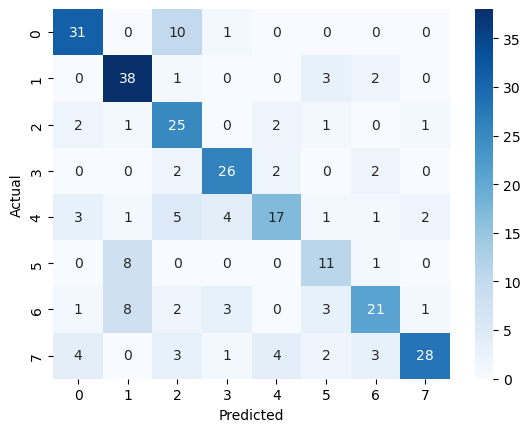

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
